In [27]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load your data
#df = pd.read_excel(r"C:\Users\bazrafka\Desktop\counting\DiscussionPaperData\Outputs\AllYearsLocationsExceptCanada.xlsx")
df = pd.read_excel(r"C:\Users\bazrafka\Desktop\counting\DiscussionPaperData\Outputs\AllYearsLocationsExceptCanadaNEW.xlsx")
# 2. Clean and format specifically for spatial analysis [cite: 109, 171]
# We drop rows where Yield, Genotype, Row, or Col are missing
df_clean = df.dropna(subset=['CorrectedYield', 'Name', 'Pas', 'Rng']).copy()

df_clean['Yield'] = pd.to_numeric(df_clean['CorrectedYield'])
df_clean['Genotype'] = df_clean['Name'].astype(str)
df_clean['Block'] = df_clean['IBLK'].astype(str)
df_clean['Row'] = df_clean['Pas'].astype(float)
df_clean['Col'] = df_clean['Rng'].astype(float)

In [28]:
# Re-running the Mixed Linear Model on the CLEANED data
# groups='Genotype' treats each variety as a random effect [cite: 186]
model = smf.mixedlm("Yield ~ Row + Col + Block", 
                    data=df_clean, 
                    groups=df_clean["Genotype"])

result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Yield      
No. Observations: 3393    Method:             REML       
No. Groups:       1020    Scale:              33.0330    
Min. group size:  1       Log-Likelihood:     -10607.0470
Max. group size:  28      Converged:          Yes        
Mean group size:  3.3                                    
---------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------
Intercept     23.333    0.514 45.360 0.000  22.325 24.341
Block[T.10]   -0.994    0.856 -1.160 0.246  -2.672  0.685
Block[T.100]   4.531    8.418  0.538 0.590 -11.968 21.031
Block[T.101]  -1.581    8.419 -0.188 0.851 -18.081 14.919
Block[T.102]  -4.094    8.419 -0.486 0.627 -20.595 12.407
Block[T.103]  -7.385    8.419 -0.877 0.380 -23.887  9.116
Block[T.104] -11.935    8.420 -1.418 0.156 -28.438  4.567
Block[T.105]  -6.964    

In [29]:
# 1. Extract the BLUPs (Random Effects)
# These represent the genetic potential corrected for spatial trends [cite: 31, 186]
blups = result.random_effects

# 2. Convert to a formatted DataFrame
# We reset the index to ensure 'Genotype' becomes a visible column in Excel
blups_df = pd.DataFrame.from_dict(blups, orient='index')
blups_df.columns = ['BLUP']
blups_df.index.name = 'Genotype'
blups_df = blups_df.reset_index()

# 3. Calculate Predicted Yield (Intercept + BLUP) 
# This value is the 'Spatial Corrected Yield' used for selection [cite: 34, 35]
intercept = result.params['Intercept']
blups_df['Predicted_Yield'] = blups_df['BLUP'] + intercept

# 4. Save to Excel with explicit headers
output_path = r"C:\Users\bazrafka\Desktop\Spatially_Corrected_Selection.xlsx"
blups_df.sort_values(by='Predicted_Yield', ascending=False).to_excel(output_path, index=False)

print(f"File saved successfully to: {output_path}")

File saved successfully to: C:\Users\bazrafka\Desktop\Spatially_Corrected_Selection.xlsx


In [30]:
# Estimate Broad-sense Heritability
var_genotype = result.cov_re.iloc[0, 0] # Genetic variance [cite: 189, 258]
var_resid = result.scale                 # Residual variance 

h2 = var_genotype / (var_genotype + var_resid)
print(f"Estimated Heritability (H2): {h2:.2f}")

Estimated Heritability (H2): 0.53


In [40]:
# 1. Base Model (No spatial correction)
model_base = smf.mixedlm("Yield ~ Block", data=df_clean, groups=df_clean["Genotype"])
result_base = model_base.fit()

h2_base = result_base.cov_re.iloc[0, 0] / (result_base.cov_re.iloc[0, 0] + result_base.scale)

# 2. Spatial Model (Your current results with Row/Col)
h2_spatial = result.cov_re.iloc[0, 0] / (result.cov_re.iloc[0, 0] + result.scale)

# 3. Comparison
precision_gain = ((h2_spatial - h2_base) / h2_base) * 100
print(f"Base Heritability: {h2_base:.2f}")
print(f"Spatial Heritability: {h2_spatial:.2f}")
print(f"Precision Gain: {precision_gain:.1f}%")

Base Heritability: 0.55
Spatial Heritability: 0.53
Precision Gain: -3.0%


In [31]:
# 1. Define selection intensity (e.g., top 10%)
intensity = 0.10
n_select = int(len(df_clean['Genotype'].unique()) * intensity)

# 2. Get top clones from Original Yield
original_top = df_clean.groupby('Genotype')['Yield'].mean().sort_values(ascending=False).head(n_select).index

# 3. Get top clones from Spatial Model (BLUPs)
spatial_top = blups_df.sort_values(by='Predicted_Yield', ascending=False).head(n_select)['Genotype']

# 4. Calculate Czekanowski Coefficient (Agreement)
# Formula: a / (a + b) where 'a' is common clones, 'b' is only in base model [cite: 283, 284]
common = len(set(original_top).intersection(set(spatial_top)))
only_original = len(set(original_top) - set(spatial_top))
cz_coefficient = common / (common + only_original)

print(f"Selection Agreement (Top 10%): {cz_coefficient:.2f}")

Selection Agreement (Top 10%): 0.53


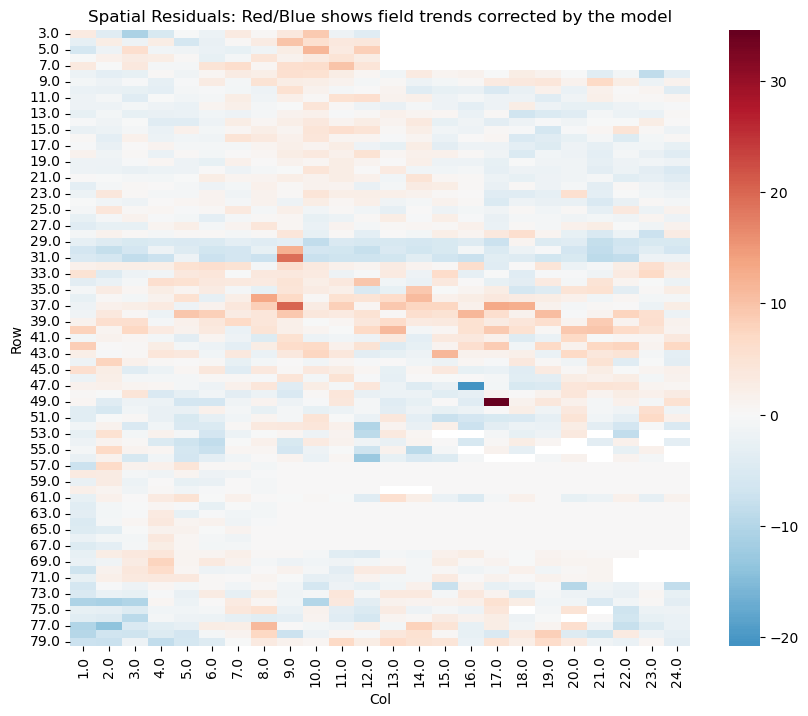

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add residuals to our cleaned dataframe
df_clean['Residuals'] = result.resid

# Create a heatmap of the field
pivot_df = df_clean.pivot_table(index='Row', columns='Col', values='Residuals')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, cmap='RdBu_r', center=0)
plt.title("Spatial Residuals: Red/Blue shows field trends corrected by the model")
plt.savefig('spatial residuals.png', dpi=350)
plt.show()

In [33]:
import pandas as pd

# 1. Calculate Original Mean Yield per Genotype
# We use the raw 'Yield' from your cleaned dataframe
original_means = df_clean.groupby('Genotype')['Yield'].mean().reset_index()
original_means.columns = ['Genotype', 'Original_Mean']
original_means['Original_Rank'] = original_means['Original_Mean'].rank(ascending=False)

# 2. Extract Spatial Results (from our 'blups_df' created earlier)
# This uses the Predicted_Yield which includes the spatial correction
spatial_results = blups_df[['Genotype', 'Predicted_Yield']].copy()
spatial_results['Spatial_Rank'] = spatial_results['Predicted_Yield'].rank(ascending=False)

# 3. Merge and Compare
comparison_df = pd.merge(original_means, spatial_results, on='Genotype')
comparison_df['Rank_Change'] = comparison_df['Original_Rank'] - comparison_df['Spatial_Rank']

# 4. Format the "Notes" column based on spatial factors
def get_note(row):
    if row['Rank_Change'] > 0:
        return "Rank Improved: Corrected for local field suppressors"
    elif row['Rank_Change'] < 0:
        return "Rank Dropped: Adjusted for high-fertility hotspots"
    return "Stable Rank"

comparison_df['Notes'] = comparison_df.apply(get_note, axis=1)

# 5. Display the Top 10 by Spatial Rank
top_comparison = comparison_df.sort_values('Spatial_Rank').head(10)
top_comparison = top_comparison[['Spatial_Rank', 'Genotype', 'Original_Rank', 'Rank_Change', 'Notes']]

# Save to Excel
top_comparison.to_excel(r"C:\Users\bazrafka\Desktop\Genotype_Rank_Comparison.xlsx", index=False)
print(top_comparison)

      Spatial_Rank Genotype  Original_Rank  Rank_Change  \
947            1.0   P25610            1.0          0.0   
946            2.0   P25609            2.0          0.0   
993            3.0   R25116            3.0          0.0   
994            4.0   R25117            4.0          0.0   
1000           5.0   S25801            5.0          0.0   
989            6.0   R25112            8.0          2.0   
624            7.0   G24212            7.0          0.0   
982            8.0   R25105            9.0          1.0   
990            9.0   R25113            6.0         -3.0   
722           10.0   K17703           11.0          1.0   

                                                  Notes  
947                                         Stable Rank  
946                                         Stable Rank  
993                                         Stable Rank  
994                                         Stable Rank  
1000                                        Stable Rank  
98

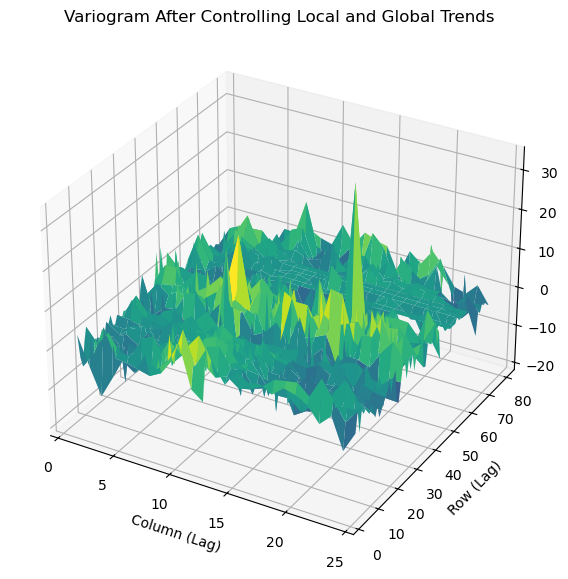

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_variogram(data, title):
    pivot = data.pivot_table(index='Row', columns='Col', values='Residuals')
    X, Y = np.meshgrid(pivot.columns, pivot.index)
    Z = pivot.values
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('Column (Lag)')
    ax.set_ylabel('Row (Lag)')
    plt.savefig('viogram.png', dpi=350)
    plt.show()

# Plotting the 'After' state based on your Mixed Model residuals
plot_variogram(df_clean, "Variogram After Controlling Local and Global Trends")

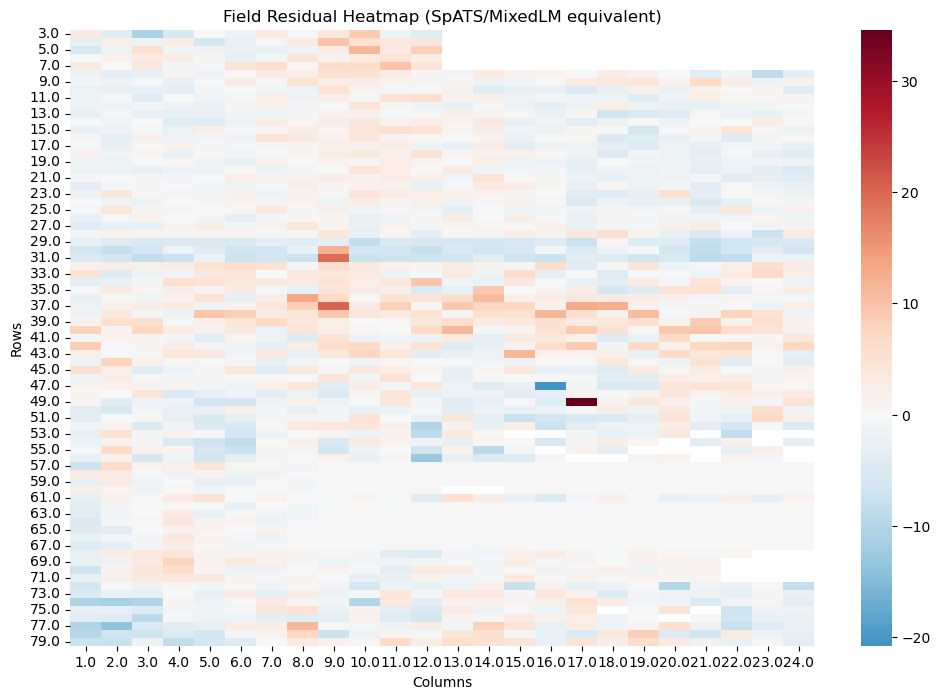

In [35]:
import seaborn as sns

plt.figure(figsize=(12, 8))
# Pivot data to create a grid matching your field layout [cite: 367, 395]
field_map = df_clean.pivot_table(index='Row', columns='Col', values='Residuals')
sns.heatmap(field_map, cmap='RdBu_r', center=0, annot=False)
plt.title("Field Residual Heatmap (SpATS/MixedLM equivalent)")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

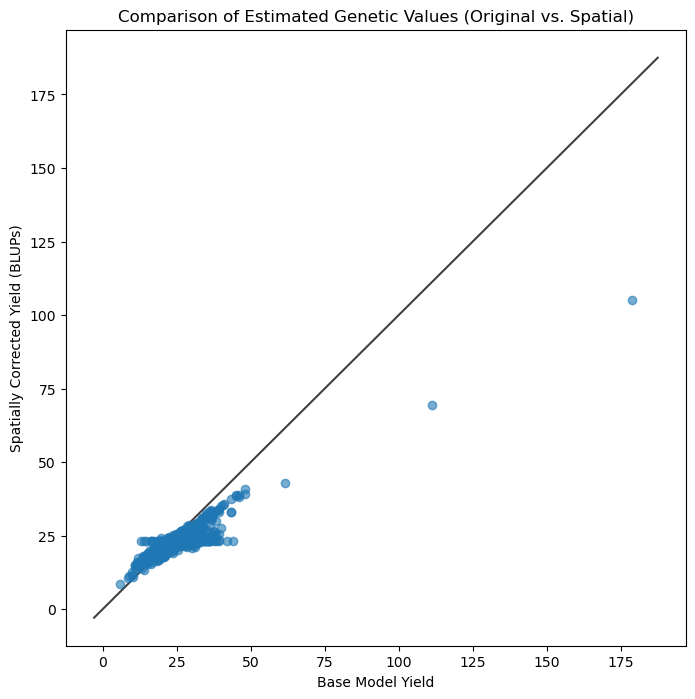

In [36]:
# Assuming you have a list of Genotypes and their Original vs Spatial Yields
plt.figure(figsize=(8, 8))
plt.scatter(comparison_df['Original_Mean'], comparison_df['Predicted_Yield'], alpha=0.6)

# Add the diagonal 1:1 line [cite: 435]
lims = [
    np.min([plt.xlim(), plt.ylim()]),
    np.max([plt.xlim(), plt.ylim()]),
]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.title("Comparison of Estimated Genetic Values (Original vs. Spatial)")
plt.xlabel("Base Model Yield")
plt.ylabel("Spatially Corrected Yield (BLUPs)")
plt.savefig('geneteic value.png', dpi=350)

plt.show()

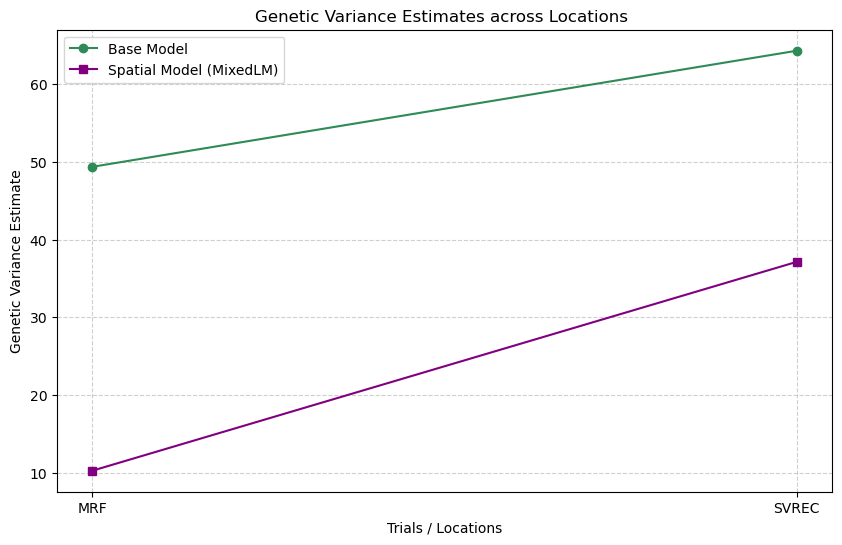

In [37]:
import matplotlib.pyplot as plt

# 1. Calculate Genetic Variance per Location for both models
# For the Base model, we look at the raw variance of means
# For the Spatial model, we extract the Group Var from the results
locations = df_clean['Location'].unique()
base_vars = []
spatial_vars = []

for loc in locations:
    loc_data = df_clean[df_clean['Location'] == loc]
    
    # Base Variance
    base_vars.append(loc_data.groupby('Genotype')['Yield'].mean().var())
    
    # Spatial Variance (Running the model per location to get specific variance)
    loc_model = smf.mixedlm("Yield ~ Row + Col", data=loc_data, groups=loc_data["Genotype"])
    loc_result = loc_model.fit()
    spatial_vars.append(loc_result.cov_re.iloc[0, 0])

# 2. Replicate Figure 5 Visualization
plt.figure(figsize=(10, 6))
plt.plot(locations, base_vars, marker='o', label='Base Model', color='seagreen')
plt.plot(locations, spatial_vars, marker='s', label='Spatial Model (MixedLM)', color='purple')

plt.title("Genetic Variance Estimates across Locations ")
plt.ylabel("Genetic Variance Estimate")
plt.xlabel("Trials / Locations")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('geneteic varience.png', dpi=350)

plt.show()

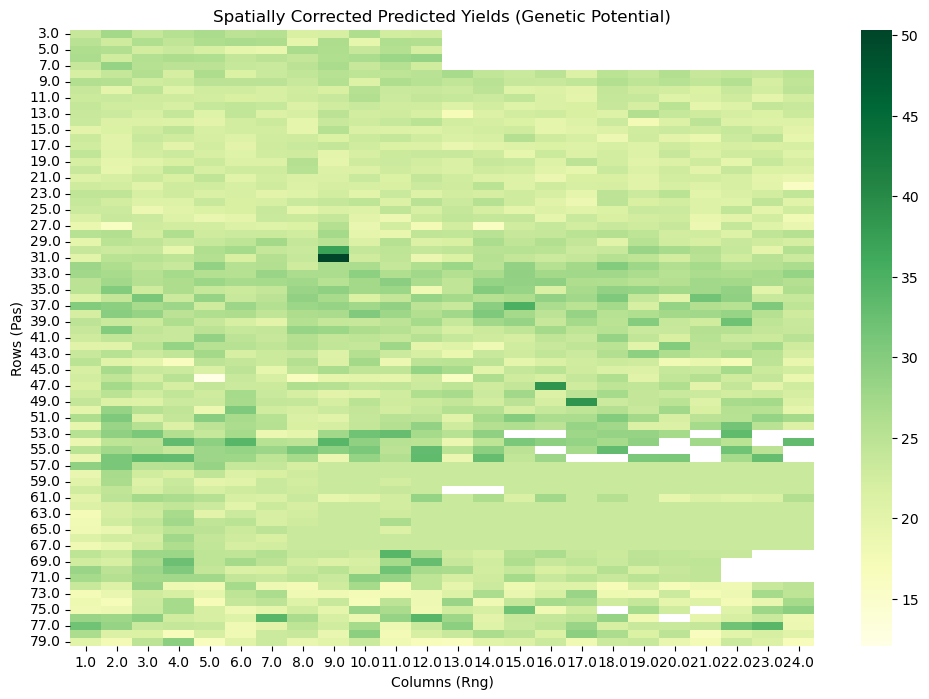

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge the predicted yields back into the spatial grid
df_final_map = df_clean.merge(blups_df[['Genotype', 'Predicted_Yield']], on='Genotype')

# Pivot for the grid layout
predicted_pivot = df_final_map.pivot_table(index='Row', columns='Col', values='Predicted_Yield')

plt.figure(figsize=(12, 8))
sns.heatmap(predicted_pivot, cmap='YlGn', annot=False)
plt.title("Spatially Corrected Predicted Yields (Genetic Potential)")
plt.xlabel("Columns (Rng)")
plt.ylabel("Rows (Pas)")
plt.savefig('Spatially Corrected Predicted Yields.png', dpi=350)

plt.show()

In [39]:
from scipy.stats import spearmanr

# 1. Prepare correlation data per location
corr_results = []
for loc in locations:
    loc_comp = comparison_df[comparison_df['Genotype'].isin(df_clean[df_clean['Location'] == loc]['Genotype'])]
    
    # Calculate Spearman Correlation
    corr, _ = spearmanr(loc_comp['Original_Rank'], loc_comp['Spatial_Rank'])
    
    corr_results.append({
        'Location': loc,
        'Spearman_Correlation': round(corr, 3)
    })

# 2. Display the Table
spearman_table = pd.DataFrame(corr_results)
print(spearman_table)

# Save to Excel
spearman_table.to_excel(r"C:\Users\bazrafka\Desktop\Spearman_Correlation_Summary.xlsx", index=False)

  Location  Spearman_Correlation
0      MRF                 0.966
1    SVREC                 0.692
